In [1]:
import pickle
import torch 
import sbibm
import numpy as np
from consbi.simulators import *
import matplotlib.pyplot as plt
from scipy.stats import binom
import numpy as np
from tqdm import tqdm
import os
from sbi.utils import posterior_nn
from sbi.inference import SNPE, prepare_for_sbi
from sbi.simulators.simutils import simulate_in_batches

from consbi import DATA_PATH, RESULTS_PATH


from sbi.analysis import pairplot

plt.style.use('../plotting_settings.mplstyle')
# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
regenerate_results = False

# Load amortized posterior.
ss = 50
with open(RESULTS_PATH.joinpath("amortized_posterior_N2000000_Default_ss50_ep1295.p"), "rb") as fh:
    prior, posterior, seed, simulator, density_estimator = pickle.load(fh).values()

In [3]:
# Sample from prior with filter for reasonable observations.
xo = torch.tensor([[0.4300, 0.4300, 0.4200, 0.6400, 0.1700, 0.4400, 0.0900]])
xo_labels = ["L4", "L4SEP", "L4SP", "L4SS", "L5PT", "L5IT", "L6"]

In [6]:
if regenerate_results:
    N = 100000
    ths = prior.sample((N,))
    batch_simulator, prior = prepare_for_sbi(simulator, prior)
    xs = simulate_in_batches(batch_simulator, ths, num_workers=20, sim_batch_size=int(N/50))
    
    with open(RESULTS_PATH.joinpath("prior_predictive_dso_100000.p"), "wb") as fh:
        pickle.dump(dict(theta=ths, x=xs, prior=prior), fh)
else:
    with open(RESULTS_PATH.joinpath("prior_predictive_dso_100000.p"), "rb") as fh:
        ths, xs, prior = pickle.load(fh).values()

In [7]:
xss = []
sss = [10, 50, 100, 1000, 10000]
for ss in sss:
    simulator.num_subsampling_pairs = ss
    sim, prior = prepare_for_sbi(simulator, prior)
    xss.append(simulate_in_batches(sim, torch.ones(1000, 3), num_workers=10, sim_batch_size=100))

In [8]:
stds_mean = np.array([float(xi.std(axis=0).mean()) for xi in xss])
stds_sem = np.array([float(xi.std(axis=0).std()/np.sqrt(7)) for xi in xss])

In [9]:
sss = np.array(sss)

In [10]:
def get_bernoulli_std(num_samples, ps):
    """Returns average sample standard deviation given number of samples and observed probabilities"""
    bernoulli_stds = []
    for p in ps.squeeze():
        bernoulli_stds.append(np.sqrt(p * (1-p)/num_samples))
    return np.mean(bernoulli_stds)

/home/janfb/anaconda3/envs/spp/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


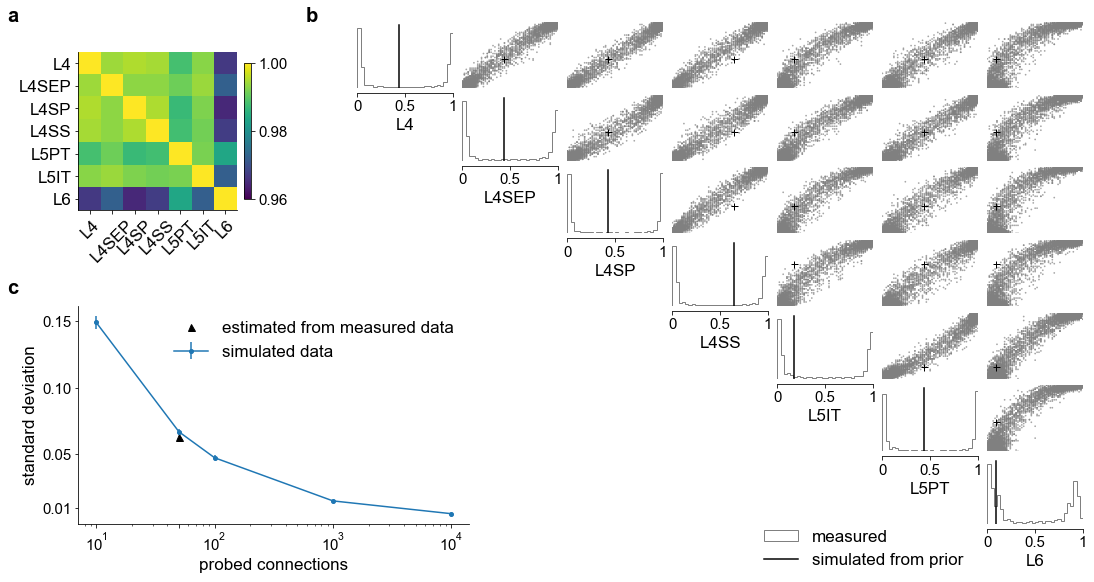

In [22]:
fig = plt.figure(figsize=(18, 9))
outer_grid = fig.add_gridspec(1, 2, wspace=-.2, hspace=0, width_ratios=[.35, .65])
data_labels = [r"L4", r"L4SEP", r"L4SP", r"L4SS", r"L5IT", r"L5PT", r"L6"]

# first column
left_grid = outer_grid[0, 0].subgridspec(2, 2, wspace=0., hspace=.3, height_ratios=[0.5, 0.5])
ax1 = left_grid.subplots() 
# Correlation matrix
plt.sca(ax1[0, 0])
plt.imshow(np.corrcoef(xs.T), vmin=0.96, vmax=1.0, cmap='viridis')
cbar = plt.colorbar(shrink=.62, orientation='vertical', pad=0.04, ticks=[0.94, 0.96, 0.98, 1.0])
# cbar.ax.tick_params(labelsize=12)
plt.xticks(np.arange(7), xo_labels, rotation=45, fontsize=plt.rcParams["axes.labelsize"]);
plt.yticks(np.arange(7), xo_labels, fontsize=plt.rcParams["axes.labelsize"])
ax1[0, 1].remove();

# variance decay
gs = ax1[1, 0].get_gridspec()
for axi in ax1[1, :]:
    axi.remove()
ax2 = fig.add_subplot(gs[1, :])
plt.sca(ax2)
plt.errorbar(sss, stds_mean, yerr=stds_sem, fmt='-o', markersize=4)
plt.semilogx(50, get_bernoulli_std(50, xo), "k^", markersize=7)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
plt.legend(["estimated from measured data", "simulated data"], frameon=False, loc=1)
plt.xlabel("probed connections")
plt.ylabel(r"standard deviation",)
plt.xticks([10, 50, 100, 1000, 10000])
plt.yticks([0.01, 0.05, 0.10, 0.15]);

# prior predictive
num_samples = 10000
right_grid = outer_grid[0, 1].subgridspec(7, 7, wspace=0.1, hspace=.1,)
ax3 = right_grid.subplots() 
color = colors[3]

fig, ax3 = pairplot(xs[:num_samples], points=xo.squeeze(),
                    limits=[[0, 1]]*7, 
                    labels=data_labels, 
                    hist_diag = dict(bins=30),
                    points_offdiag=dict(marker="+", markersize=7),
                    points_colors=["k"],
                    upper="scatter",
                    diag="hist",
                    scatter_offdiag=dict(s=3, alpha=0.7),
                    contour_offdiag=dict(levels=[0.99]),
                    samples_colors=["gray"], #[colors[3]],
                    axes=ax3, 
                    fig=fig,
                   )

# dot, = plt.plot(0.1, "o", c=color, markersize=4);
# h[1] = dot
plt.sca(ax3[0,0])
plt.legend(["measured", "simulated from prior"], 
           bbox_to_anchor=(4.1, -6.45),
#               bbox_to_anchor=(-.2, -1.),
           loc=2)
# ax3[2, 0].legend(h, l, 
#                 frameon=False, markerscale=2, 
#                 bbox_to_anchor=(0.49, .62),
#                 bbox_transform=plt.gcf().transFigure);

weight = "bold"
fontsize = 20
x = 0.07
y = 0.9
fig.text(x, y, "a", fontsize=fontsize, fontweight=weight)
fig.text(.3, y, "b", fontsize=fontsize, fontweight=weight)
fig.text(x, 0.48, "c", fontsize=fontsize, fontweight=weight);
plt.tight_layout();

In [23]:
for ftype in ["png", "pdf", "eps"]:
    fig.savefig(f"supp_fig4_prior_predictive.{ftype}", dpi=300, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
